# Мобильное приложение по продаже продуктов питания 

## Общее описание проекта

Имеется мобильное приложение по продаже продуктов питания. С целью улучшения взаимодействия пользователей с приложением дизайнеры поменяли шрифты. Однако для принятия окончательного решения о переходе на приложение с новыми шрифтами проведен `A/B`-тест: 
- группа пользователей `A` работа со старой версией приложения;
- группа пользователей `B` работа с новой версией приложения.


В Вашем распоряжении результаты проведенного `A/B`-теста. Необходимо выяснить повлияло ли изменение шрифтов на поведение пользователей.

## Описание данных 

Имеется лог-файл, содержащий информацию о действиях пользователя нашего мобильного приложения. Каждая запись в логе — это действие пользователя, или событие.

|Признак|Описание|
|----:|:----|
|EventName | название события|
|DeviceIDHash | уникальный идентификатор пользователя|
|EventTimestamp | время события|
|ExpId | номер эксперимента: 247 контрольная группа, а 248 — экспериментальная|

## Инструкция по выполнению проекта
- Шаг 1. Открыть файл с данными и изучить общую информацию
- Шаг 2. Подготовить данные
    - Заменить названия столбцов на удобные для вас;
    - Проверить пропуски и типы данных. Откорректировать, если нужно;
    - Добавить столбец даты и времени, а также отдельный столбец дат;
- Шаг 3. Изучить и проверить данные
    - Сколько всего событий в логе?
    - Сколько всего пользователей в логе?
    - Сколько в среднем событий приходится на пользователя?
    - Данными за какой период мы располагаем? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. Можно ли быть уверенным, что данные одинаково полные за весь период? Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?
    - Много ли событий и пользователей потеряли, отбросив старые данные?
    - Проверить, что у нас есть пользователи из всех групп.
- Шаг 4. Изучить воронку событий
    - Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте.
    - Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.
    - Предположить, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
    - По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
    - На каком шаге теряете больше всего пользователей?
    - Какая доля пользователей доходит от первого события до оплаты?
- Шаг 5. Изучить результаты эксперимента
    - Сколько пользователей в каждой группе?
    - Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой группе. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий?
    - Сделать выводы из эксперимента.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных

In [2]:
df = pd.read_csv('ab_test.csv', 
                 delimiter = '\t')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,PaymentScreenSuccessful,3518123091307005509,1564054127,248
1,CartScreenAppear,3518123091307005509,1564054127,248
2,PaymentScreenSuccessful,6217807653094995999,1564055322,248
3,CartScreenAppear,6217807653094995999,1564055323,248
4,MainScreenAppear,1850981295691852772,1564086702,247
...,...,...,...,...
163817,MainScreenAppear,2300292234025330845,1565211957,247
163818,MainScreenAppear,5317814261427487562,1565212162,248
163819,OffersScreenAppear,5317814261427487562,1565212167,248
163820,OffersScreenAppear,5317814261427487562,1565212208,248


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       163822 non-null  object
 1   DeviceIDHash    163822 non-null  int64 
 2   EventTimestamp  163822 non-null  int64 
 3   ExpId           163822 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.0+ MB


In [4]:
df.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,1.638220e+05,1.638220e+05,163822.000000
mean,4.667422e+18,1.564911e+09,247.523416
std,2.582490e+18,1.773846e+05,0.499453
min,6.909562e+15,1.564054e+09,247.000000
25%,2.458858e+18,1.564754e+09,247.000000
50%,4.623192e+18,1.564917e+09,248.000000
75%,6.887424e+18,1.565072e+09,248.000000
max,9.222603e+18,1.565212e+09,248.000000


In [5]:
df.loc[df.duplicated()].shape[0]

290

In [6]:
var_desc = ['EventName', 'ExpId']

for col in var_desc:
    print('----{}----'.format(col))
    print(df[col].unique()) 
    print('--------')
    

----EventName----
['PaymentScreenSuccessful' 'CartScreenAppear' 'MainScreenAppear'
 'Tutorial' 'OffersScreenAppear']
--------
----ExpId----
[248 247]
--------


# Предобработка данных

1. Корректировка заголовков; 
2. Преобразование типов;
3. Удаление дублей.


## Корректировка заголовков

In [7]:
df.columns = ['event_name', 'user_id', 'event_date_time', 'exp_id']

In [8]:
# df.rename({'':'',
           
#            axis = 1})

In [9]:
df.columns

Index(['event_name', 'user_id', 'event_date_time', 'exp_id'], dtype='object')

In [10]:
df['event_date_time'] = pd.to_datetime(df['event_date_time'], origin='unix', unit = 's')

In [11]:
df.head(2)

,event_name,user_id,event_date_time,exp_id
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       163822 non-null  object        
 1   user_id          163822 non-null  int64         
 2   event_date_time  163822 non-null  datetime64[ns]
 3   exp_id           163822 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.0+ MB


In [13]:
df['event_date'] = df.event_date_time.dt.date

In [14]:
df

,event_name,user_id,event_date_time,exp_id,event_date
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
2,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
3,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
4,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
...,...,...,...,...,...
163817,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247,2019-08-07
163818,MainScreenAppear,5317814261427487562,2019-08-07 21:09:22,248,2019-08-07
163819,OffersScreenAppear,5317814261427487562,2019-08-07 21:09:27,248,2019-08-07
163820,OffersScreenAppear,5317814261427487562,2019-08-07 21:10:08,248,2019-08-07


In [15]:
#df_new = df.loc[~df.duplicated()]

df.drop_duplicates(inplace = True)

In [16]:
df.duplicated().sum()

0

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163532 entries, 0 to 163821
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       163532 non-null  object        
 1   user_id          163532 non-null  int64         
 2   event_date_time  163532 non-null  datetime64[ns]
 3   exp_id           163532 non-null  int64         
 4   event_date       163532 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 7.5+ MB


# Изучить и проверить данные

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы располагаем? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. Можно ли быть уверенным, что данные одинаково полные за весь период? Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?
- Много ли событий и пользователей потеряли, отбросив старые данные?
- Проверить, что у нас есть пользователи из всех групп.


In [18]:
print('''Всего событий --- {}. 
Уникальных событий --- {}.'''.format(df.shape[0], 
                                     len(df.event_name.unique())))

Всего событий --- 163532. 
Уникальных событий --- 5.


In [19]:
print('Всего пользователей --- {}.'.format(df.user_id.nunique()))

Всего пользователей --- 5062.


In [20]:
len(df.user_id.unique())

5062

In [21]:
#Сколько в среднем событий приходится на пользователя?
int(df.groupby('user_id').event_name.count().mean())

32

In [22]:
int(df.groupby('user_id').event_name.count().median())

20

In [23]:
int(df.groupby('user_id').event_name.count().mode()[0])

5

In [24]:
# Данными за какой период мы располагаем? 
# Найти максимальную и минимальную дату. 
# Построить гистограмму по дате и времени. 
# Можно ли быть уверенным, что данные одинаково полные за весь период? 
# Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?

In [25]:
df.event_date.min()

datetime.date(2019, 7, 25)

In [26]:
df.event_date.max()

datetime.date(2019, 8, 7)

In [27]:
df.event_date.max() - df.event_date.min()

datetime.timedelta(days=13)

In [28]:
df.event_date.unique()

array([datetime.date(2019, 7, 25), datetime.date(2019, 7, 26),
       datetime.date(2019, 7, 27), datetime.date(2019, 7, 28),
       datetime.date(2019, 7, 29), datetime.date(2019, 7, 30),
       datetime.date(2019, 7, 31), datetime.date(2019, 8, 1),
       datetime.date(2019, 8, 2), datetime.date(2019, 8, 3),
       datetime.date(2019, 8, 4), datetime.date(2019, 8, 5),
       datetime.date(2019, 8, 6), datetime.date(2019, 8, 7)], dtype=object)

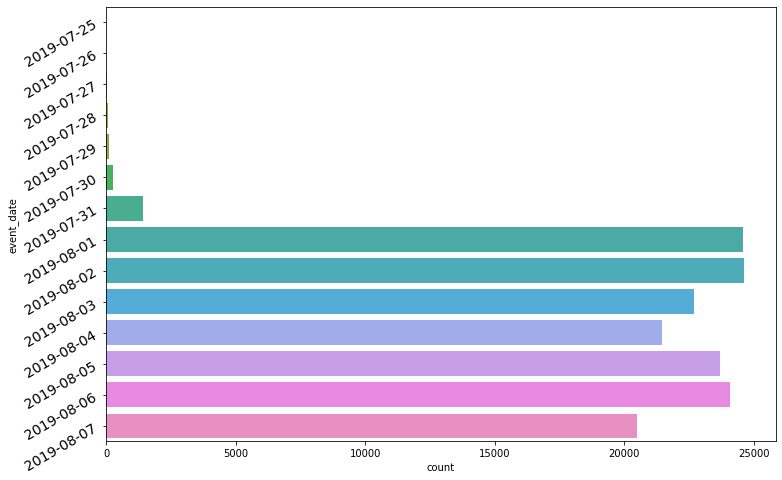

In [29]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()
ax = sns.countplot(y = 'event_date', data = df)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30, fontsize = 14);


In [30]:
df.columns

Index(['event_name', 'user_id', 'event_date_time', 'exp_id', 'event_date'], dtype='object')

In [31]:
df.groupby('event_date').event_name.count().reset_index()#.agg(count_event_day = ('event_name', 'count')).reset_index()
#df.columns = []

,event_date,event_name
0,2019-07-25,5
1,2019-07-26,17
2,2019-07-27,31
3,2019-07-28,72
4,2019-07-29,129
5,2019-07-30,283
6,2019-07-31,1410
7,2019-08-01,24580
8,2019-08-02,24608
9,2019-08-03,22707


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163532 entries, 0 to 163821
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       163532 non-null  object        
 1   user_id          163532 non-null  int64         
 2   event_date_time  163532 non-null  datetime64[ns]
 3   exp_id           163532 non-null  int64         
 4   event_date       163532 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.5+ MB


In [33]:
df = df.astype({'event_date': 'datetime64'})

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163532 entries, 0 to 163821
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       163532 non-null  object        
 1   user_id          163532 non-null  int64         
 2   event_date_time  163532 non-null  datetime64[ns]
 3   exp_id           163532 non-null  int64         
 4   event_date       163532 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.5+ MB


In [35]:
df_act = df[df['event_date'] >= '2019-08-01'] # dt.date(2019, 8, 1) -- если не преобразовывать типы, то можно задать дату dt.date(2019, 8, 1)

In [36]:
print('Потерено {:.2%} данных'.format((df.shape[0]-df_act.shape[0])/df.shape[0]))

Потерено 1.19% данных


In [37]:
df_act.groupby('exp_id').user_id.nunique() 

exp_id
247    2513
248    2537
Name: user_id, dtype: int64

- <s>Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте.</s>
- <s>Посчитать, сколько пользователей совершали каждое из этих событий. </s> 

- <s>Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.</s>
- <s>Предположить, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.</s>
- По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

In [38]:
df_act.event_name.value_counts()

MainScreenAppear           79652
OffersScreenAppear         31566
CartScreenAppear           27613
PaymentScreenSuccessful    22066
Tutorial                     688
Name: event_name, dtype: int64

In [39]:
(df_act.groupby('event_name').\
    agg(count_event = ('event_name', 'count')).\
    reset_index().\
    sort_values(by = 'count_event', 
                ascending = False)
)

,event_name,count_event
1,MainScreenAppear,79652
2,OffersScreenAppear,31566
0,CartScreenAppear,27613
3,PaymentScreenSuccessful,22066
4,Tutorial,688


In [40]:
df_act.columns

Index(['event_name', 'user_id', 'event_date_time', 'exp_id', 'event_date'], dtype='object')

In [41]:
df_new = (df_act.groupby('event_name').\
    agg(count_users_event = ('user_id', 'nunique')).\
    reset_index().\
    sort_values(by = 'count_users_event', 
                ascending = False)
)

In [42]:
df_new['percent_users_event'] = np.round(df_new['count_users_event']/df_act.user_id.nunique()*100, 2)

In [43]:
df_new

,event_name,count_users_event,percent_users_event
1,MainScreenAppear,4969,98.40
2,OffersScreenAppear,3051,60.42
0,CartScreenAppear,2468,48.87
3,PaymentScreenSuccessful,2339,46.32
4,Tutorial,562,11.13


In [44]:
df_new = df_new[df_new.event_name !='Tutorial']

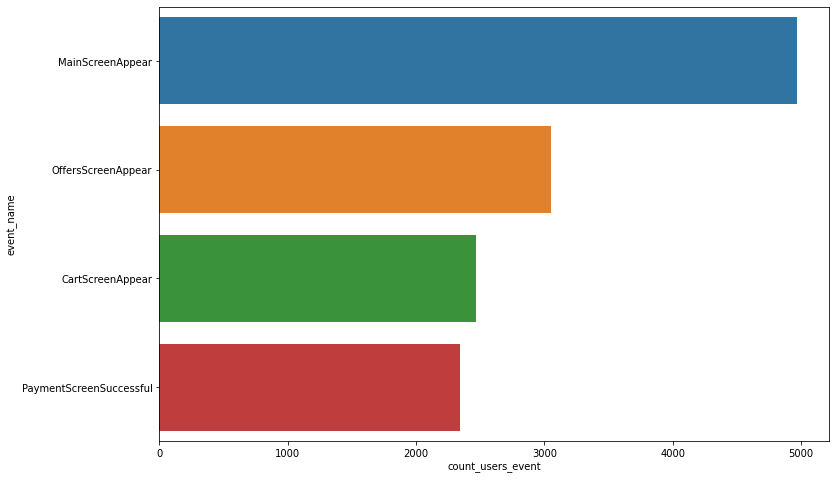

In [45]:
fig = plt.figure(figsize = (12,8))
ax = plt.axes()
ax = sns.barplot(x ='count_users_event',
                 y = 'event_name',
                 data = df_new) 

In [46]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = df_new['event_name'],
    x = df_new['count_users_event'],
    textposition = "inside",
    textinfo = "value+percent initial"
    #opacity = 0.65, 
    # marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    # "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    # connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    ))

fig.show()

- Сколько пользователей в каждой группе?
- Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой группе. 
- Посчитать долю пользователей, совершивших это событие. 
- Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий?

In [47]:
df_act = df_act[df_act.event_name != 'Tutorial']

In [48]:
df_act.columns

Index(['event_name', 'user_id', 'event_date_time', 'exp_id', 'event_date'], dtype='object')

In [49]:
df_act.groupby('exp_id').agg(users_in_group = ('user_id', 'nunique'))


,users_in_group
exp_id,
247,2512
248,2535


In [51]:
df_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160897 entries, 1949 to 163821
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       160897 non-null  object        
 1   user_id          160897 non-null  int64         
 2   event_date_time  160897 non-null  datetime64[ns]
 3   exp_id           160897 non-null  int64         
 4   event_date       160897 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 7.4+ MB


In [58]:
df1 = df_act[df_act.exp_id == 247].groupby('event_name').\
agg(users_in_group_247 = ('user_id', 'nunique')).\
reset_index().sort_values(by = 'users_in_group_247', ascending = False)

In [59]:
df2 = df_act[df_act.exp_id == 248].groupby('event_name').\
agg(users_in_group_248 = ('user_id', 'nunique')).\
reset_index().sort_values(by = 'users_in_group_248', ascending = False)

In [61]:
df1.merge(df2, on = 'event_name')

,event_name,users_in_group_247,users_in_group_248
0,MainScreenAppear,2476,2493
1,OffersScreenAppear,1520,1531
2,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181


In [65]:
df_act.groupby(['exp_id', 'event_name']).\
agg(users_in_group_247 = ('user_id', 'nunique')).sort_values(by = 'users_in_group_247', ascending = False)

users_in_group_247
exp_id event_name                                 
248    MainScreenAppear                       2493
247    MainScreenAppear                       2476
248    OffersScreenAppear                     1531
247    OffersScreenAppear                     1520
       CartScreenAppear                       1238
248    CartScreenAppear                       1230
       PaymentScreenSuccessful                1181
247    PaymentScreenSuccessful                1158

In [76]:
pd.pivot_table(data = df_act, 
               index = 'event_name',
               columns='exp_id',
               values='user_id',
               aggfunc='nunique').reset_index().\
               sort_values(by = 247, ascending = False)

               

exp_id,event_name,247,248
1,MainScreenAppear,2476,2493
2,OffersScreenAppear,1520,1531
0,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181


In [79]:
df_funnel = df1.merge(df2, on = 'event_name')
df_funnel

,event_name,users_in_group_247,users_in_group_248
0,MainScreenAppear,2476,2493
1,OffersScreenAppear,1520,1531
2,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181


In [83]:
df_funnel['percent_users_in_group_247'] = np.round(df_funnel['users_in_group_247'] / df_act[df_act.exp_id == 247].\
                                          user_id.nunique() * 100, 2) 
df_funnel['percent_users_in_group_248'] = np.round(df_funnel['users_in_group_248'] / df_act[df_act.exp_id == 248].\
                                          user_id.nunique() * 100, 2)

In [84]:
df_funnel

,event_name,users_in_group_247,users_in_group_248,percent_users_in_group_247,percent_users_in_group_248
0,MainScreenAppear,2476,2493,98.57,98.34
1,OffersScreenAppear,1520,1531,60.51,60.39
2,CartScreenAppear,1238,1230,49.28,48.52
3,PaymentScreenSuccessful,1158,1181,46.10,46.59


In [82]:
2476 / 2512

0.9856687898089171

In [68]:
set(df_act[df_act.exp_id == 247].user_id).intersection(set(df_act[df_act.exp_id == 248].user_id))

set()

In [67]:
df_act[df_act.exp_id == 248].user_id

1954      4613461174774205834
1955      4613461174774205834
1956      4613461174774205834
1957      4613461174774205834
1958      4613461174774205834
                 ...         
163809    8249271441488197538
163811    8249271441488197538
163818    5317814261427487562
163819    5317814261427487562
163820    5317814261427487562
Name: user_id, Length: 84213, dtype: int64